## Data Setup


In [27]:
import dataset
import utils
import reference_impl as ref
import model
import simulator as sim

# Use this cfg variable whenever we need to access some constant
cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=64,
    num_subcarriers=160,
    train_test_split=0.8,
    data_root="",
    # duplicate_data=1,
    # data_snr=-1
)

train_set, test_set = dataset.load_data(cfg)

## Offline Training


In [28]:
import matlab.engine
matlab = matlab.engine.start_matlab()

In [29]:
pca = ref.ReferencePCA(cfg, matlab)
model.train_or_load(pca, cfg.pca_path, cfg.retrain_all, train_set.csi_samples)  # pca.fit() includes reduce overhead

Reducing offloading overhead...


In [30]:
zdl_train = pca.process(train_set.csi_samples)                # N * zdl_len

windows_shape = train_set.csi_windows.shape                   # N * window_size * na * nc
zdl_train_windows = train_set.csi_windows.reshape(            # (N * window_size) * na * nc
    -1, windows_shape[2], windows_shape[3]
)
zdl_train_windows = pca.process(zdl_train_windows)
zdl_train_windows = zdl_train_windows.reshape(
    windows_shape[0], windows_shape[1], zdl_train.shape[1]
)  # N * window_size * zdl_len

In [10]:
## Train Predictor
predictor = ref.NullPredictor()                               # With NullPredictor, prediction_error is just zDL! This lets us test the ref impl
model.train_or_load(predictor, cfg.predictor_path, cfg.retrain_all, zdl_train, zdl_train_windows)
predicted_zdl = predictor.process(zdl_train_windows)

prediction_error = zdl_train - predicted_zdl

In [11]:
## Error Compression
error_compressor = ref.ReferenceKmeans(cfg, matlab)
model.train_or_load(error_compressor, cfg.kmeans_path, cfg.retrain_all, prediction_error)

# DL and UL each get trained pca, predictor, and error_compressor

Training k-means clustering...
Considering bTot: 100
Considering bTot: 200
Considering bTot: 300
Considering bTot: 400
Considering bTot: 500
Considering bTot: 600
Considering bTot: 700
Considering bTot: 800
Considering bTot: 900
Considering bTot: 1000
Considering bTot: 1100
Considering bTot: 1200


  0%|          | 0/9 [00:00<?, ?it/s]

## Visualize?


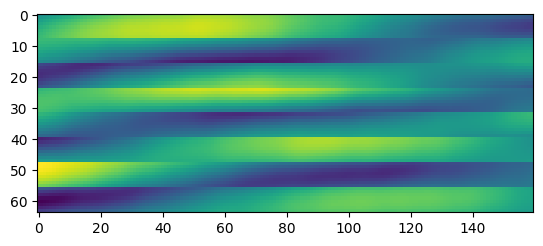

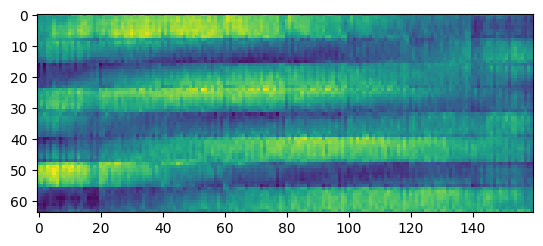

In [12]:
# Verify PCA is working!

import numpy as np
import matplotlib.pyplot as plt
ori = np.expand_dims(test_set[1].csi, axis=0)
plt.imshow(np.squeeze(np.abs(ori)))
plt.figure()

single_zdl = pca.process(ori)
recovered = pca.decode(single_zdl)
plt.imshow(np.squeeze(np.abs(recovered)))

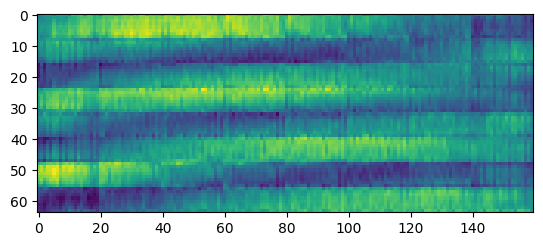

In [13]:
# Kmeans is also working!
quantized_zdl = error_compressor.process(single_zdl)
padded_zdl = error_compressor.decode(quantized_zdl)
quantized_recovered = pca.decode(padded_zdl)
plt.imshow(np.squeeze(np.abs(quantized_recovered)))

# Testing

In [1]:
## Downlink Side
zdl_test = pca.process(test_set.csi_samples)
# Bit allocation?
print(zdl_test)
predicted_zdl_test = predictor.process(zdl_test)
prediction_error_test = zdl_test - predicted_zdl
compressed_error_test = error_compressor.process(predicted_zdl_test)

# CHANNEL: Send compressed_error to UL

## UL Side
ul_predicted_error = error_compressor.decode(compressed_error_test)
ul_predicted_zdl = predictor.process(zdl_test)
# TODO ? Shouldn't be test_set Might need to do this iteratively like loop over each sample and load the History 
ul_reconstructed_zdl = ul_predicted_error + ul_predicted_zdl
ul_predicted_csi = pca.decode(ul_reconstructed_zdl)

## TODO Compute Accuracy 
# test_set.csi_samples == ul_reconstructed_zdl


NameError: name 'pca' is not defined

## Simulation
- "End to End" Simulation
- Show simulation of entire new "test" path made up of portions of paths that were trained on

In [ ]:
# Load in pretrained components
dl_sim: sim.DLSimulator = sim.DLSimple(cfg, pca, predictor, error_compressor)
ul_sim: sim.ULSimulator = sim.ULSimple(cfg, pca, predictor, error_compressor)

evaluator = sim.Evaluator()

for sample in test_set:
    quantized_error = dl_sim.simulate(sample)
    # Send quantized_error over CHANNEL
    predicted_csi = ul_sim.simulate(quantized_error)
    evaluator.evaluate(sample, predicted_csi)
    
evaluator.report()
evaluator.visualize()

In [9]:
"""
Run this cell to reload all modules

When making changes to classes in Python files, either restarting the kernel or reloading modules is necessary
In order to support reloading modules, use
    import mymodule
or
    import mymodule as m
syntax for our own modules, instead of 'from mymodule import thing'
"""

import importlib
importlib.reload(utils)
importlib.reload(dataset)
importlib.reload(model)
importlib.reload(sim)
importlib.reload(ref)

<module 'reference_impl' from '/Users/dziper/UCSD/F24/ECE 257A/NonstaticCSI/project/reference_impl.py'>